In [165]:
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import glob
import os
import contextily as ctx
from scipy.spatial import cKDTree
from shapely.geometry import Point
import json
from tqdm.auto import tqdm
pd.set_option('min_rows', 30)
import sys
sys.path.append('..')
from importlib import reload
# import src.utils as utils
# reload(utils)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 12)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

In [2]:
%%time
## read in and get bounds
df = pd.read_csv("input/BCs_issued_by_AUP_TLADCs_2021FEB.csv")
bcs = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_Coordinate, df.Y_Coordinate))
# get bounds of data set (with a small buffer), useful for clipping other datasets
bcs = bcs.set_crs(epsg=4326)
bounds4326 = bcs.total_bounds
bcs = bcs.to_crs(epsg=3857)
bounds3857 =  bcs.total_bounds

CPU times: user 38.2 s, sys: 552 ms, total: 38.7 s
Wall time: 38.7 s


In [143]:
## add small buffer to bounds
x_delta3857 = bounds3857[2] - bounds3857[0]
y_delta3857 = bounds3857[3] - bounds3857[1]
bounds_buffered3857 = [bounds3857[0] - y_delta3857 / 200, bounds3857[1] - x_delta3857 / 200, bounds3857[2] + y_delta3857 / 200, bounds3857[3] + x_delta3857 / 200]
bounds_buffered3857
x_delta4326 = bounds4326[2] - bounds4326[0]
y_delta4326 = bounds4326[3] - bounds4326[1]
bounds_buffered4326 = [bounds4326[0] - y_delta4326 / 200, bounds4326[1] - x_delta4326 / 200, bounds4326[2] + y_delta4326 / 200, bounds4326[3] + x_delta4326 / 200]
bounds_buffered4326

[174.15865864485, -37.2937968355, 175.54295485515, -35.877583094500004]

In [3]:
# one address has no ADDRESS_1, but an ADDRESS_2 with a leading digit
display(bcs[bcs.ADDRESS_1.isna() & ~bcs.ADDRESS_2.isna()][bcs[bcs.ADDRESS_1.isna() & ~bcs.ADDRESS_2.isna()].ADDRESS_2.str.contains('^[0-9]', regex=True)])
# move address 2 to address 1 for that one BC...
bcs.loc[bcs.OBS == 146813, 'ADDRESS_1'] = "25 HOLLYFORD DRV"
bcs.loc[bcs.OBS == 146813, 'ADDRESS_2'] = ""

,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,geometry
64127,146813,"Sep 01, 2013 12:00:00 AM","Mar 01, 2013 12:00:00 AM",NaN,25 HOLLYFORD DRV,CLOVER PARK,Howick,"New (and pre-built) house, unit, bach, crib, b...",1100,239.0,240000.0,1,Residential,Detached,NaN,NaN,1998,716014.0,2013.0,Residential - Mixed Housing Suburban Zone,Residential,18.0,MCC_MR,Main Residential,Residential,NaN,NaN,NaN,174.896997,-36.986932,POINT (19469444.625 -4437285.457)


In [52]:
%%time
# get number and name of street (but not 'road', 'street', 'place' etc), for matching with addresses
def number_name_bc(x):
    """extract street number and first complete word of the street name from building consents"""
    if x.ADDRESS_1 is None:
        pass
    else:
        # get number and first word of address
        joined_address = ' '.join([str(x[f'ADDRESS_{i}']) for i in [1,2, 3]]).lower()
        return ' '.join(joined_address.split(' ')[:2])

def full_address_bc(x):
    """extract full address from building consents"""
    if x.ADDRESS_1 is None:
        pass
    else:
        # get number and first word of address
        joined_address = ' '.join([str(x[f'ADDRESS_{i}']) for i in [1,2, 3] if not str(x[f'ADDRESS_{i}']) == 'nan']).lower()
        return joined_address

bcs['number_name'] = bcs.apply(number_name_bc, axis=1)
bcs['full_address'] = bcs.apply(full_address_bc, axis=1)
# to have successfully extracted the name as the second 'word': the last character is never numeric
# print(sum(bcs['number_name'].apply(lambda x: x[-1] in [i for i in range(10)])))
# there will still be some cases where there is no street number
display(bcs.number_name.sample(5))

0


71493      nan seaview
73016       28a kokiri
102144    nan motutapu
158549      56 exmouth
56853       17 wrybill
Name: number_name, dtype: object

CPU times: user 17.1 s, sys: 48.6 ms, total: 17.1 s
Wall time: 17.1 s


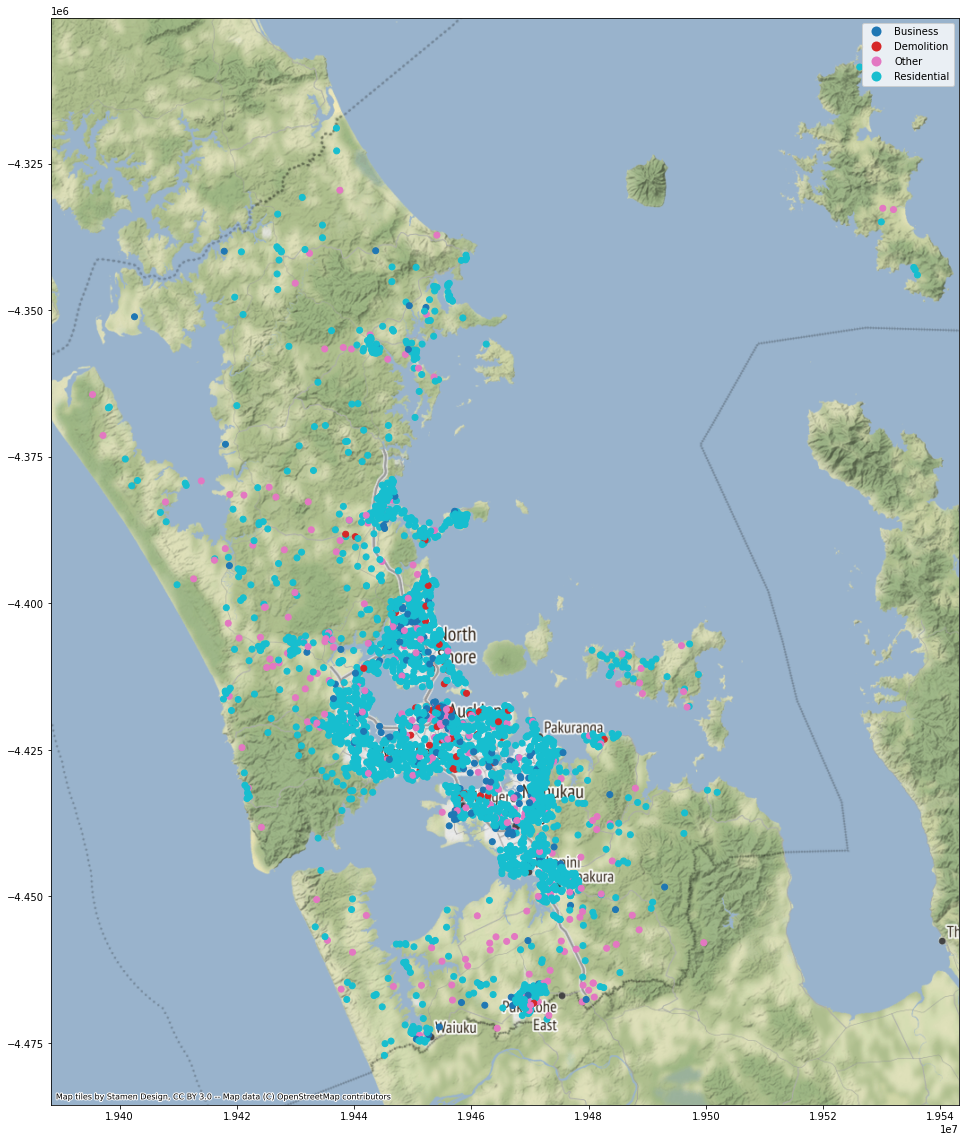

In [28]:
ax = bcs.sample(3000).plot(column='Building_Type_Group', legend=True, figsize=(20,20))
ctx.add_basemap(ax)

In [96]:
# split into three branches: those with an address number range (e.g. 10-20), those with a single number (e.g. 10), and those with no number
# those with no number cannot be matched with addresses to get a more accuract coordinate
bcs_non_na = bcs[~bcs.ADDRESS_1.isna()]
bcs_ranged = bcs_non_na[bcs_non_na.ADDRESS_1.str.contains('^[0-9]-[0-9]', regex=True)]
# get all bcs which start with a digit
bcs_numbered = bcs_non_na[bcs_non_na.ADDRESS_1.str.contains('^[0-9]', regex=True)]
# exclude those in bcs_ranged
bcs_numbered = bcs_numbered[~bcs_numbered.ADDRESS_1.str.contains('^[0-9]-[0-9]', regex=True)]
bcs_others = pd.concat([bcs_non_na[~bcs_non_na.ADDRESS_1.str.contains('^[0-9]', regex=True)], bcs[bcs.ADDRESS_1.isna()]])
print('non na:', len(bcs_non_na))
print('1. ranged:', len(bcs_ranged))
print('2. numbered:', len(bcs_numbered))
print('3. non ranged/non numbered:', len(bcs_others))
print('total bcs:', len(bcs))
print('sum of 1, 2, 3:', len(bcs_ranged) + len(bcs_numbered) + len(bcs_others))

non na: 193005
1. ranged: 1105
2. numbered: 188175
3. non ranged/non numbered: 17946
total bcs: 207226
sum of 1, 2, 3: 207226


In [142]:
bcs_ranged.sample(5)

,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,geometry,number_name,full_address
29051,180627,"Jun 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",5-9 PODGORA AVENUE,Huapai,Auckland,Rodney,"Townhouses, flats, units, and other dwellings",1129,163.0,390000.0,1,Residential,Attached,NaN,NaN,2014,214900.0,2013.0,Residential - Mixed Housing Suburban Zone,Residential,18.0,RDC_7,Future Urban,Rural,NaN,Huapai Triangle,Huapai Triangle,174.537549,-36.778199,POINT (19429431.057 -4408235.509),5-9 podgora,5-9 podgora avenue huapai auckland
207216,151357,"Jul 01, 2014 12:00:00 AM","Mar 01, 2015 12:00:00 AM",9-11,FENTON ST,EDEN TERRACE,Waitemata,New Flats,1200,3760.0,3000000.0,37,Residential,Attached,NaN,NaN,1998,419702.0,2013.0,Business - Mixed Use Zone,Business,12.0,ACC_10,Business MU,Business,Commercial,NaN,NaN,174.757447,-36.868315,POINT (19453909.968 -4420767.514),9-11 fenton,9-11 fenton st eden terrace
36324,173858,"Aug 01, 2017 12:00:00 AM","Mar 01, 2018 12:00:00 AM",1-83 HOBSONVILLE POINT ROAD,Hobsonville,Auckland,Upper Harbour,Apartments,1121,0.0,10000.0,0,Residential,Attached,NaN,NaN,2014,221907.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_16,Special Area,Special,NaN,"Scott Point, Sunderland Precinct, Hobsonville ...","Scott Point, Sunderland Precinct, Hobsonville ...",174.654918,-36.795932,POINT (19442496.536 -4410700.359),1-83 hobsonville,1-83 hobsonville point road hobsonville auckland
174507,94582,"Dec 01, 2003 12:00:00 AM","Apr 01, 2004 12:00:00 AM",2-4,SUNNYNOOK RD,SUNNYNOOK,Devonport - Takapuna,"New (and pre-built) house, unit, bach, crib, b...",1100,160.0,155000.0,1,Residential,Detached,NaN,NaN,1998,189902.0,2013.0,Residential - Mixed Housing Suburban Zone,Residential,18.0,NSC_541,Residential 4A,Residential,NaN,NaN,NaN,174.746296,-36.751504,POINT (19452668.733 -4404525.991),2-4 sunnynook,2-4 sunnynook rd sunnynook
57884,141576,"Oct 01, 2012 12:00:00 AM","Mar 01, 2012 12:00:00 AM",1-5,WOODCOCKS RD,WARKWORTH,Rodney,"New (and pre-built) house, unit, bach, crib, b...",1100,124.0,250000.0,1,Residential,Detached,NaN,NaN,1998,140500.0,2013.0,Residential - Single House Zone,Residential,19.0,RDC_27,Residential Medium Inten,Residential,NaN,NaN,NaN,174.657216,-36.406081,POINT (19442752.304 -4356642.325),1-5 woodcocks,1-5 woodcocks rd warkworth


## Get more accurate coordinates from NZ addresses dataset

In [14]:
# addressing of building consents is very inconsistent
# some building consents have street name in ADDRESS_2, some have suburb, some even have 'Auckland'
bcs[bcs.ADDRESS_2 == 'Auckland'].sample(5)

,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,geometry
24601,188214,"Nov 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",528 DON BUCK ROAD,Auckland,NaN,Henderson - Massey,Non-building construction,3111,0.0,40000.0,1,Other,NaN,NaN,NaN,2014,226402.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_6,Foothills,Rural,NaN,Redhills (Fred Taylor Drive) � Stage 1,Redhills (Fred Taylor Drive) � Stage 1,174.603215,-36.824411,POINT (19436740.940 -4414660.154)
24605,188218,"Nov 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",528 DON BUCK ROAD,Auckland,NaN,Henderson - Massey,"Townhouses, flats, units, and other dwellings",1129,129.0,233100.0,1,Residential,Attached,NaN,NaN,2014,226402.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_6,Foothills,Rural,NaN,Redhills (Fred Taylor Drive) � Stage 1,Redhills (Fred Taylor Drive) � Stage 1,174.603215,-36.824411,POINT (19436740.940 -4414660.154)
24606,188219,"Nov 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",528 DON BUCK ROAD,Auckland,NaN,Henderson - Massey,"Townhouses, flats, units, and other dwellings",1129,104.0,188640.0,1,Residential,Attached,NaN,NaN,2014,226402.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_6,Foothills,Rural,NaN,Redhills (Fred Taylor Drive) � Stage 1,Redhills (Fred Taylor Drive) � Stage 1,174.603215,-36.824411,POINT (19436740.940 -4414660.154)
24614,188227,"Nov 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",524-526 Don Buck Road,Auckland,NaN,Henderson - Massey,"Townhouses, flats, units, and other dwellings",1129,135.0,216000.0,1,Residential,Attached,NaN,NaN,2014,226403.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_7,Living,Residential,NaN,Redhills (Fred Taylor Drive) � Stage 1,Redhills (Fred Taylor Drive) � Stage 1,174.607308,-36.824848,POINT (19437196.626 -4414720.873)
24618,188231,"Nov 01, 2018 12:00:00 AM","Mar 01, 2019 12:00:00 AM",528 DON BUCK ROAD,Auckland,NaN,Henderson - Massey,"Townhouses, flats, units, and other dwellings",1129,136.0,245622.0,1,Residential,Attached,NaN,NaN,2014,226402.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_6,Foothills,Rural,NaN,Redhills (Fred Taylor Drive) � Stage 1,Redhills (Fred Taylor Drive) � Stage 1,174.603215,-36.824411,POINT (19436740.940 -4414660.154)


In [7]:
%%time
## read in address dataset and add number_name, just like for BCs
# https://data.linz.govt.nz/layer/53353-nz-street-address/
addresses = gpd.read_file('input/lds-nz-street-address-GPKG-CLIPPED.gpkg').to_crs(3857)
def number_name_addresses(x):
    return ' '.join(x.full_address.split(' ')[:2]).lower()
addresses['number_name'] = addresses.apply(number_name_addresses, axis=1)

/data/miniconda3/envs/house-upzone/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


CPU times: user 1min 40s, sys: 10.3 s, total: 1min 50s
Wall time: 1min 50s


In [146]:
addresses[(addresses.address_number == 9) & (addresses.full_road_name == 'Hopetoun Street')].sample(3)

,address_id,change_id,address_type,unit_value,address_number,address_number_suffix,address_number_high,water_route_name,water_name,suburb_locality,town_city,full_address_number,full_road_name,full_address,road_section_id,gd2000_xcoord,gd2000_ycoord,water_route_name_ascii,water_name_ascii,suburb_locality_ascii,town_city_ascii,full_road_name_ascii,full_address_ascii,geometry,number_name
513858,1915410,2991250,Road,802,9,None,NaN,None,None,Freemans Bay,Auckland,802/9,Hopetoun Street,"802/9 Hopetoun Street, Freemans Bay, Auckland",189772,174.752374,-36.858544,None,None,Freemans Bay,Auckland,Hopetoun Street,"802/9 Hopetoun Street, Freemans Bay, Auckland",POINT (19453345.297 -4419407.917),802/9 hopetoun
513947,1989293,2991217,Road,106,9,None,NaN,None,None,Freemans Bay,Auckland,106/9,Hopetoun Street,"106/9 Hopetoun Street, Freemans Bay, Auckland",189772,174.752374,-36.858544,None,None,Freemans Bay,Auckland,Hopetoun Street,"106/9 Hopetoun Street, Freemans Bay, Auckland",POINT (19453345.297 -4419407.917),106/9 hopetoun
513864,1915440,2991243,Road,601,9,None,NaN,None,None,Freemans Bay,Auckland,601/9,Hopetoun Street,"601/9 Hopetoun Street, Freemans Bay, Auckland",189772,174.752374,-36.858544,None,None,Freemans Bay,Auckland,Hopetoun Street,"601/9 Hopetoun Street, Freemans Bay, Auckland",POINT (19453345.297 -4419407.917),601/9 hopetoun


In [141]:
# and alternative matching would have been to take the digits + the first n characters of each address up to but not including 'road', drive', 'avenue' etc... but that would have been messy
set([x.split(' ')[-1] for x in addresses.full_road_name])

{'1',
 '12',
 '16',
 '2',
 'Access',
 'Anchorage',
 'Ara-Kotinga',
 'Avenue',
 'Bay',
 'Boardwalk',
 'Boulevard',
 'Brae',
 'Broadway',
 'Bypass',
 'Carrowmore',
 'Central',
 'Circle',
 'Circus',
 'Close',
 'Common',
 'Concourse',
 'Court',
 'Courtneys',
 'Cove',
 'Crescent',
 'Crest',
 'Dale',
 'Dell',
 'Downs',
 'Drive',
 'Earlsway',
 'East',
 'Enclave',
 'End',
 'Esplanade',
 'Extension',
 'Fairway',
 'Fen',
 'Furlong',
 'Garden',
 'Gardens',
 'Glade',
 'Glebe',
 'Glen',
 'Goldfield',
 'Green',
 'Greens',
 'Grove',
 'Gully',
 'Harbour',
 'Haven',
 'Heights',
 'Highway',
 'Hill',
 'Hilltop',
 'Ho',
 'Homestead',
 'Island',
 'Isle',
 'Kingsway',
 'Knoll',
 'Landing',
 'Lane',
 'Lea',
 'Link',
 'Lochview',
 'Loop',
 'Mall',
 'Meadway',
 'Mermaid',
 'Mews',
 'Mile',
 'Motu',
 'Neptune',
 'Nook',
 'North',
 'Oaks',
 'Oasis',
 'Oho',
 'Oval',
 'Parade',
 'Park',
 'Parkway',
 'Pass',
 'Place',
 'Plaza',
 'Point',
 'Priors',
 'Prom',
 'Promenade',
 'Quadrant',
 'Queensway',
 'Reach',
 'Retr

In [97]:
%time
addresses_tree = cKDTree(np.array(list(addresses.geometry.apply(lambda x: (x.x, x.y)))))
bcs_numbered_tree = cKDTree(np.array(list(bcs_numbered.geometry.apply(lambda x: (x.x, x.y)))))
bcs_ranged_tree = cKDTree(np.array(list(bcs_ranged.geometry.apply(lambda x: (x.x, x.y)))))

In [178]:
# test some radii to see which is suitable
bcs_numbered_sample = bcs_numbered.sample(1000)
bcs_numbered_sample_tree = cKDTree(np.array(list(bcs_numbered_sample.geometry.apply(lambda x: (x.x, x.y)))))
matches = {}
for r in [10, 50, 100, 175] + list(range(250, 3251, 250)):
    matches[r] = []
    # list of lists: ith sub list contains indices of use_tree points within r of the ith data_tree point
    bcs_numbered_neighbours = bcs_numbered_sample_tree.query_ball_tree(addresses_tree, r)
    for i, neighbours in tqdm(enumerate(bcs_numbered_neighbours)):
        # check how many matches there are
        matches[r].append(np.sum(bcs_numbered_sample.iloc[i].number_name == addresses.iloc[neighbours].number_name))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

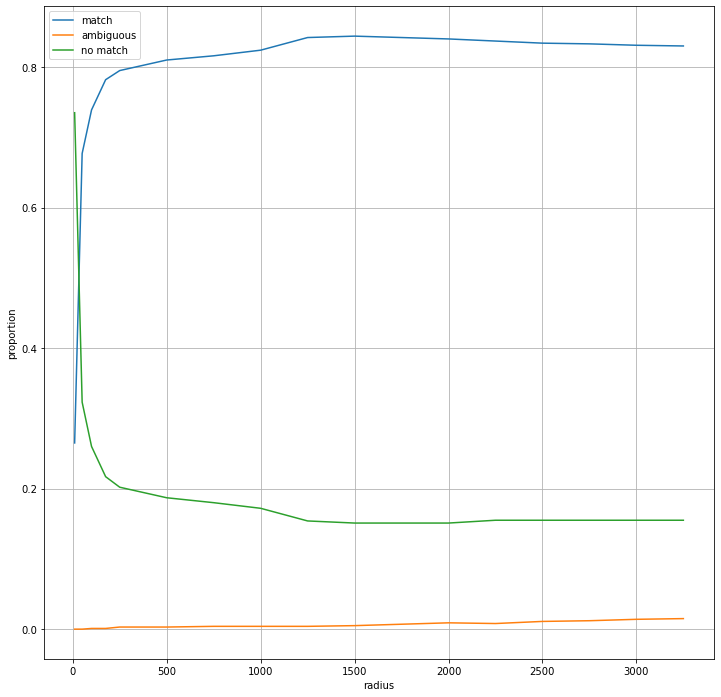

In [184]:
# for r in sorted(matches.keys()):
#     print('####', r, '####')
#     print('match:', np.sum(np.array(matches[r]) == 1) / len(matches[r]))
#     print('ambiguous:', np.sum(np.array(matches[r]) > 1) / len(matches[r]))
#     print('no match:', np.sum(np.array(matches[r]) == 0) / len(matches[r]))
r_list = list(sorted(matches.keys()))
ax = plt.subplot(1,1,1)
ax.plot(r_list, [np.sum(np.array(matches[r]) == 1) / len(matches[r]) for r in r_list], label='match')
ax.plot(r_list, [np.sum(np.array(matches[r]) > 1) / len(matches[r]) for r in r_list], label='ambiguous')
ax.plot(r_list, [np.sum(np.array(matches[r]) == 0) / len(matches[r]) for r in r_list], label='no match')
ax.legend()
plt.xlabel('radius')
plt.ylabel('proportion')
plt.grid()

In [ ]:
# test some radii to see which is suitable
def unique_radius_column_match(left, right, left_col, right_col, r, left_tree=None, right_tree=None):
    """find points in right that are within r of points in left and uniquely match on a column"""
    if right_tree is None:
        right_tree = cKDTree(np.array(list(right.geometry.apply(lambda x: (x.x, x.y)))))
    if left_tree is None:
        left_tree = cKDTree(np.array(list(left.geometry.apply(lambda x: (x.x, x.y)))))
    
    # specify columns and initialize neighbour information dictionary if using the less efficient method
    # columns = ('address_id', 'full_address', 'geometry')
    # neighbour_information = {c: [] for c in columns}
    match_indices = []
    # list of lists: ith sub list contains indices of right points within r of the ith left point
    left_tree_neighbours = left_tree.query_ball_tree(addresses_tree, r)
    for i, neighbours in tqdm(enumerate(left_tree_neighbours), total=len(left_tree_neighbours)):
        # subset right to those within r distance
        right_neighbours = addresses.iloc[neighbours]
        # check how many matches there are
        match_indicator = left.iloc[i][left_col] == right_neighbours[right_col]
        if np.sum(match_indicator) == 1:
            # extract the index from right_neighbours
            # extracting the index only and later subsetting the full addresses dataframe
            # results in a ~4x speed up over extracting the requisite addresses information within this for loop
            match_indices.append(right_neighbours[match_indicator].index[0])
        else:
            match_indices.append(-1)
    return match_indices
            
r = 1250
match_col = 'number_name'
unique_radius_column_match(bcs_numbered_sample, addresses, match_col, match_col, r, right_tree=addresses_tree)

In [254]:
# add empty row with index -1; this will be retrieved if there is no match address match
addresses.loc[-1] = addresses.loc[1]
for c in addresses.columns:
    addresses.loc[-1, c] = np.nan
    addresses.loc[-1, c]
addresses.loc[-1]

address_id                 NaN
change_id                  NaN
address_type               NaN
unit_value                 NaN
address_number             NaN
address_number_suffix      NaN
address_number_high        NaN
water_route_name           NaN
water_name                 NaN
suburb_locality            NaN
town_city                  NaN
full_address_number        NaN
full_road_name             NaN
full_address               NaN
road_section_id            NaN
gd2000_xcoord              NaN
gd2000_ycoord              NaN
water_route_name_ascii     NaN
water_name_ascii           NaN
suburb_locality_ascii      NaN
town_city_ascii            NaN
full_road_name_ascii       NaN
full_address_ascii         NaN
geometry                  None
number_name                NaN
Name: -1, dtype: object

In [73]:
match_indicator = [i == 'no_match' for i in results[200]]

In [120]:
addresses[addresses.full_address.str.contains('7 Tonar')]

,address_id,change_id,address_type,unit_value,address_number,address_number_suffix,address_number_high,water_route_name,water_name,suburb_locality,town_city,full_address_number,full_road_name,full_address,road_section_id,gd2000_xcoord,gd2000_ycoord,water_route_name_ascii,water_name_ascii,suburb_locality_ascii,town_city_ascii,full_road_name_ascii,full_address_ascii,geometry,number_name
109830,1110063,982478,Road,None,87,None,NaN,None,None,Northcote,Auckland,87,Tonar Street,"87 Tonar Street, Northcote, Auckland",185607,174.750480,-36.798123,None,None,Northcote,Auckland,Tonar Street,"87 Tonar Street, Northcote, Auckland",POINT (19453134.455 -4411005.031),87 tonar
565812,1857389,4805687,Road,None,27,None,NaN,None,None,Northcote,Auckland,27,Tonar Street,"27 Tonar Street, Northcote, Auckland",393397,174.747768,-36.795866,None,None,Northcote,Auckland,Tonar Street,"27 Tonar Street, Northcote, Auckland",POINT (19452832.523 -4410691.261),27 tonar
584309,1110037,5158462,Road,None,7,None,NaN,None,None,Northcote,Auckland,7,Tonar Street,"7 Tonar Street, Northcote, Auckland",399789,174.746008,-36.795107,None,None,Northcote,Auckland,Tonar Street,"7 Tonar Street, Northcote, Auckland",POINT (19452636.620 -4410585.644),7 tonar
603685,1109986,5368710,Road,None,63,None,67.0,None,None,Northcote,Auckland,63-67,Tonar Street,"63-67 Tonar Street, Northcote, Auckland",400241,174.749348,-36.797217,None,None,Northcote,Auckland,Tonar Street,"63-67 Tonar Street, Northcote, Auckland",POINT (19453008.404 -4410878.988),63-67 tonar


In [74]:
bcs_filtered.iloc[sample_idx].iloc[match_indicator]

,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,geometry,number_name,full_address
72902,56935,"Mar 01, 1999 12:00:00 AM","Apr 01, 1999 12:00:00 AM",603,TE ATATU RD,TE ATATU NORTH,Henderson - Massey,Demolitions - OTHER BUILDINGS ONLY,4910,0.0,70000.0,1,Demolition,NaN,NaN,NaN,1998,250105.0,2013.0,Open Space - Conservation Zone,Public Open Space,31.0,WCC_14,Open Space,Other,NaN,NaN,NaN,174.658933,-36.842599,POINT (19442943.451 -4417189.725),603 te,603 te atatu rd te atatu north
190285,78681,"Mar 01, 2002 12:00:00 AM","Apr 01, 2002 12:00:00 AM",651,TE ATATU RD,TE ATATU NORTH,Henderson - Massey,"New (and pre-built) house, unit, bach, crib, b...",1100,75.0,58000.0,1,Residential,Detached,NaN,NaN,1998,248700.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,174.653951,-36.837122,POINT (19442388.913 -4416427.931),651 te,651 te atatu rd te atatu north
7892,216614,"Jun 01, 2020 12:00:00 AM","Mar 01, 2020 12:00:00 AM",55 FIRTH STREET,Drury,Auckland,Papakura,"Townhouses, flats, units, and other dwellings",1129,29.0,58000.0,1,Residential,Attached,NaN,NaN,2014,808701.0,2013.0,Business - Light Industry Zone,Business,17.0,PDC_14,Industrial 3,Business,Industrial,NaN,NaN,174.949136,-37.101086,POINT (19475248.690 -4453206.251),55 firth,55 firth street drury auckland
159136,110044,"Feb 01, 2006 12:00:00 AM","Apr 01, 2006 12:00:00 AM",3,DURBIN COURT,GREENHITHE,Upper Harbour,"New (and pre-built) house, unit, bach, crib, b...",1100,178.0,133500.0,1,Residential,Detached,NaN,NaN,1998,181305.0,2013.0,Residential - Large Lot Zone,Residential,23.0,NSC_625,Area B: Large Lot Reside,Special,NaN,NaN,NaN,174.682047,-36.778398,POINT (19445516.489 -4408263.198),3 durbin,3 durbin court greenhithe
47663,162518,"Jan 01, 2016 12:00:00 AM","Mar 01, 2016 12:00:00 AM",2 LEADERSHIP CRESCENT,PAPAKURA,NaN,Papakura,Houses,1111,135.0,189000.0,1,Residential,Detached,NaN,NaN,2014,765600.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,PDC_51,Residential 8,Special,NaN,Takanini Strategic Area,Takanini - Strategic Area,174.943703,-37.050715,POINT (19474643.880 -4446178.218),2 leadership,2 leadership crescent papakura
21459,194223,"Mar 01, 2019 12:00:00 AM","Mar 01, 2019 12:00:00 AM",2 NGAHUE DRIVE,Stonefields,Auckland,Orakei,Houses,1111,0.0,5000.0,0,Residential,Detached,NaN,NaN,2014,465304.0,2013.0,Residential - Terrace Housing and Apartment Bu...,Residential,8.0,ACC_30,Residential 8b,Residential,NaN,NaN,NaN,174.838628,-36.883376,POINT (19462947.084 -4422863.381),2 ngahue,2 ngahue drive stonefields auckland
181653,87290,"Mar 01, 2003 12:00:00 AM","Apr 01, 2003 12:00:00 AM",39-41,SEYMOUR RD,SUNNYVALE,Waitakere Ranges,"New (and pre-built) house, unit, bach, crib, b...",1100,116.0,82000.0,1,Residential,Detached,NaN,NaN,1998,278108.0,2013.0,Residential - Terrace Housing and Apartment Bu...,Residential,8.0,WCC_7,Living,Residential,NaN,NaN,NaN,174.630802,-36.900026,POINT (19439811.922 -4425180.903),39-41 seymour,39-41 seymour rd sunnyvale
129390,678,"May 01, 1991 12:00:00 AM","Apr 01, 1992 12:00:00 AM",2/2,EVANS RD,GLEN EDEN,Waitakere Ranges,New Flats,1200,125.0,115000.0,1,Residential,Attached,NaN,NaN,1998,286500.0,2013.0,Residential - Terrace Housing and Apartment Bu...,Residential,8.0,WCC_9,Living 2,Residential,NaN,NaN,NaN,174.652720,-36.912884,POINT (19442251.856 -4426970.942),2/2 evans,2/2 evans rd glen eden
4411,222768,"Oct 01, 2020 12:00:00 AM","Mar 01, 2020 12:00:00 AM",19 GALWAY STREET,Onehunga,Auckland,Maungakiekie - Tamaki,School buildings,2312,195.0,NaN,1,Other,NaN,NaN,NaN,2014,602401.0,2013.0,Business - Heavy Industry Zone,Business,5.0,ACC_7,Business 6,Business,Industrial,NaN,NaN,174.790316,-36.928850,POINT (19457568.984 -4429193.968),19 galway,19

In [319]:
for k, result in results.items():
    print('-------', k, '-------')
    for s in ['match', 'no_match', 'ambiguous']:
        print(s, sum([r == s for r in result]) / len(result))

------- 200 -------
match 0.806
no_match 0.194
ambiguous 0.0
------- 1000 -------
match 0.81
no_match 0.188
ambiguous 0.002
------- 5000 -------
match 0.814
no_match 0.18
ambiguous 0.006


In [299]:
# number of building consents that don't have NA for ADDRESS_1, and also don't have an address starting with a number
len([a for a in bcs[~bcs.ADDRESS_1.isna()].ADDRESS_1 if not a[0] in [str(i) for i in range(10)]])

3725

## Join BCs with NZ Parcels

In [37]:
%%time
nz_parcels = gpd.read_file('input/lds-nz-primary-parcels-FGDB.zip!nz-primary-parcels.gdb')
print(nz_parcels.crs)
nz_parcels = nz_parcels.to_crs(3857)
nz_parcels = nz_parcels.cx[bounds_buffered3857[0]:bounds_buffered3857[2], bounds_buffered3857[1]:bounds_buffered3857[3]]

epsg:4167
CPU times: user 3min 58s, sys: 1.15 s, total: 3min 59s
Wall time: 3min 59s


In [45]:
nz_parcels = nz_parcels.cx[bounds_buffered3857[0]:bounds_buffered3857[2], bounds_buffered3857[1]:bounds_buffered3857[3]]

In [40]:
nz_parcels

,id,appellation,affected_surveys,parcel_intent,topology_type,statutory_actions,land_district,titles,survey_area,calc_area,geometry
0,5266447,None,None,Hydro,Primary,None,North Auckland,None,NaN,1289690.0,"MULTIPOLYGON (((-12155911.950 495830.979, -121..."
1,4789727,Part Lot 3 Allot 64 Section 1 SBRS OF Auckland,SO 663,DCDB,Primary,None,North Auckland,None,NaN,1.0,"MULTIPOLYGON (((-12296010.220 369113.384, -122..."
2,4810316,Part Tidal Lands of Manukau Harbour Survey Off...,SO 67474,DCDB,Primary,[Create] Revested in the Crown Sec 5 Foreshore...,North Auckland,None,31600000.0,31342451.0,"MULTIPOLYGON (((-12349176.218 373759.767, -123..."
3,4817943,Crown Land Survey Office Plan 58175,SO 58175,DCDB,Primary,[Create] Crown Land Reserved from Sale Sec 58 ...,North Auckland,None,NaN,467490.0,"MULTIPOLYGON (((-12183771.380 518898.007, -121..."
4,4827816,Lot 2 DP 165098,DP 165098,DCDB,Primary,None,North Auckland,NA99B/977,22979.0,22972.0,"MULTIPOLYGON (((-12254746.365 394243.168, -122..."
5,4937273,Lot 2 DP 38555,DP 38555,DCDB,Primary,None,North Auckland,NA7A/846,726.0,727.0,"MULTIPOLYGON (((-12311163.341 359403.649, -123..."
6,4991598,Lot 161 DP 6975,DP 6975,DCDB,Primary,[Create] Historic Reserve [Kawau Island Histor...,North Auckland,None,1012.0,1045.0,"MULTIPOLYGON (((-12174704.920 398868.292, -121..."
7,5008028,Lot 3 DP 155195,DP 155195,DCDB,Primary,None,North Auckland,"NA92C/966, NA94A/279",12.0,12.0,"MULTIPOLYGON (((-12306276.415 367050.209, -123..."
8,5014167,Crown Land,None,DCDB,Primary,[Create] Riverbank Reserve Sec 129 Land Act 1924,North Auckland,None,NaN,181271.0,"MULTIPOLYGON (((-12225342.686 475656.177, -122..."
9,5030697,Lot 4 DP 61316,DP 61316,DCDB,Primary,None,North Auckland,NA18B/1061,5.0,5.0,"MULTIPOLYGON (((-12303511.996 347847.490, -123..."


# join with SA2s

In [13]:
sa2 = gpd.read_file('NZ-SA/statistical-area-2-2020-generalised.gdb')
sa2 = sa2.to_crs(3857)

In [20]:
gpd.sjoin(bc_sample, sa2)

,OBS,CONSENT_DATE,MARCH_YEAR,ADDRESS_1,ADDRESS_2,ADDRESS_3,LB_Name,BUILDING_TYPE_NAME,BUILDING_TYPE_CODE,FLOOR_AREA,VALUE,BUILDINGS,Building_Type_Group,Residential_Type,Business_Group,Business_Category,Type_Class_Year,MBCODE,MBYEAR,AUP_BaseZone,AUP_BaseZone_Group,ZONE,ZONE_ID,ZONE_NAME,ZONE_TYPE,BUSINESS_TYPE,PlanAreaName,SHA_Name_154,X_Coordinate,Y_Coordinate,geometry,index_right,SA22020_V1_00,SA22020_V1_00_NAME,SA22020_V1_00_NAME_ASCII,LAND_AREA_SQ_KM,AREA_SQ_KM,SHAPE_Length
6440,219437,"Aug 01, 2020 12:00:00 AM","Mar 01, 2020 12:00:00 AM",13 GRIFFEN PARK ROAD,Mount Roskill,Auckland,Puketapapa,"Townhouses, flats, units, and other dwellings",1129,634.0,NaN,3,Residential,Attached,NaN,NaN,2014,587000.0,2013.0,Residential - Terrace Housing and Apartment Bu...,Residential,8.0,ACC_24,Residential 6a,Residential,NaN,NaN,NaN,174.719937,-36.920856,POINT (19449734.429 -4428080.845),1006,139600,Lynfield North,Lynfield North,0.940925,0.940925,5537.544865
203270,65577,"Mar 01, 2000 12:00:00 AM","Apr 01, 2000 12:00:00 AM",,DUNN RD,DRURY,Franklin,"New (and pre-built) house, unit, bach, crib, b...",1100,207.0,95000.0,1,Residential,Detached,NaN,NaN,1998,815401.0,2013.0,Road,General,27.0,NaN,NaN,NaN,NaN,NaN,NaN,175.052449,-37.151529,POINT (19486749.463 -4460249.110),1233,166400,Ararimu,Ararimu,90.925442,90.925442,58867.417446
66156,144992,"May 01, 2013 12:00:00 AM","Mar 01, 2013 12:00:00 AM",39,BEACHWOOD DR,HATFIELDS BEACH,Hibiscus and Bays,"New (and pre-built) house, unit, bach, crib, b...",1100,203.0,354000.0,1,Residential,Detached,NaN,NaN,1998,170807.0,2013.0,Residential - Single House Zone,Residential,19.0,RDC_27,Residential Medium Inten,Residential,NaN,NaN,NaN,174.686288,-36.567512,POINT (19445988.651 -4378993.739),621,112800,Hatfields Beach,Hatfields Beach,0.923252,0.923252,4314.585524
91368,39665,"Jan 01, 1997 12:00:00 AM","Apr 01, 1997 12:00:00 AM",45,PALOMINO DR,WESTERN HEIGHTS,Henderson - Massey,"New (and pre-built) house, unit, bach, crib, b...",1100,210.0,100000.0,1,Residential,Detached,NaN,NaN,1998,281514.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_7,Living,Residential,NaN,NaN,NaN,174.623138,-36.898135,POINT (19438958.803 -4424917.654),908,128300,McLaren Park,McLaren Park,1.088384,1.088384,4957.562154
10567,211720,"Mar 01, 2020 12:00:00 AM","Mar 01, 2020 12:00:00 AM",61 CLARK ROAD,Hobsonville,Auckland,Upper Harbour,"Townhouses, flats, units, and other dwellings",1129,95.0,240000.0,1,Residential,Attached,NaN,NaN,2014,222800.0,2013.0,Residential - Mixed Housing Urban Zone,Residential,60.0,WCC_16,Special Area,Special,NaN,"Scott Point, Sunderland Precinct, Hobsonville ...","Scott Point, Sunderland Precinct, Hobsonville ...",174.654705,-36.799413,POINT (19442472.770 -4411184.328),71,120200,Hobsonville Point,Hobsonville Point,3.521568,3.521568,11979.226387
